# **Llama-3.1-8B-Classification, No LoRa**
## **Classification of validation data; 2 Labels as scale**



In [1]:
!pip install huggingface_hub
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install --upgrade wandb
!pip install adapter-transformers

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
adapters 1.1.1 requires transformers~=4.48.3, but you have transformers 4.51.3 which is incompatible.
  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.3-py3-none-any.whl (9.7 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [ ]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools 
from tqdm import tqdm
import bitsandbytes as bnb
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer,
                        AutoModel,
                        AutoConfig,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)
from peft import PeftModel
from huggingface_hub import login
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.getcwd()

'/home/jovyan/llama_final/Validation'

## **Authenticate for Hugging Face**

In [4]:
# Hugging face access

with open("../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

In [5]:
torch.cuda.empty_cache()
torch.cuda.is_available()
#torch.cuda.device_count()

True

In [6]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [7]:
with open("../../login/wandb.txt", 'r') as f: 
    WB_TOKEN = str(f.read())

wandb.login(key=WB_TOKEN)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: elena-solar (elena-solar-university-of-konstanz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## **Reimport Pretrained Model**

In [9]:
# file paths
base_model = "meta-llama/Llama-3.1-8B" 
finetuned_path = "../Classification/two_labels/noLoRa/Llama_3.1_8B_saved_model_2labels_head_only"

data_path = "data/validation_sample_small.csv"

output_path = "output/Llama_3.1_8B_ft_no_LoRa_val.csv"



In [19]:

tokenizer = AutoTokenizer.from_pretrained(finetuned_path)

model = AutoModelForSequenceClassification.from_pretrained(
    finetuned_path,
    torch_dtype=torch.float16,   
    device_map="cuda")




Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device) 

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128001)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,

# **Data**

In [10]:
# validation sample
data = pd.read_csv(data_path)
data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit
0,d02aba,ez5hk92,ez5yhvc,"That strategy requires less manpower, less cas...",Because the main objective was to secure the o...,May I get a source for this?,Ask_Politics
1,4gqdyw,d2jsh7b,d2k49x6,It seems that everywhere I go recently I hear ...,This question was asked yesterday.,And the day before that,Ask_Politics
2,9kru18,e719ohl,e719y1u,So after the big headline yesterday about the ...,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Ask_Politics
3,5oui9g,dcm9yt7,dcnqde5,My father tells me trade deals are good for th...,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Ask_Politics
4,4eakff,d1yfonw,d1ygjpd,It sounds controversial and non-traditional to...,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Ask_Politics
5,pxu6lc,hermw07,hetwgsp,I understand that it's more complicated than p...,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Ask_Politics
6,27j18j,ci1ityc,ci1n1c7,Although most if not all were lead by a party ...,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Ask_Politics
7,jn2bon,gb05qjo,gb05rnn,I'm from Canada and it seems to me that most o...,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Ask_Politics
8,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics
9,kzc2cq,gjp0hl0,gjrl8gu,Conservatives long ago lost so many key insti...,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Ask_Politics


In [11]:
# dictionary for conversions
label_dict = {1: "disagree", 0 : "no_disagreement"}


In [12]:
# make text

def create_training_data(data):

    result = []

    for idx, row in data.iterrows():
        #system_prompt = """You are a classification Chatbot. Given a comment and a reply, you classify whether the reply agrees, disagrees or is neutral towards the comment. You only reply with either "agree", "disagree" or "neutral" and nothing else."""
        comment = row["body_parent"]
        reply = row["body_child"]
        #label = row["label"]
        #target = row["target"]
        result.append({'comment' : comment, 'reply': reply})
    
    return result

# save data
df = pd.DataFrame(create_training_data(data))
df

,comment,reply
0,Because the main objective was to secure the o...,May I get a source for this?
1,This question was asked yesterday.,And the day before that
2,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th..."
3,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!
4,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state..."
5,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...
6,The nominally communist regimes called themsel...,The nominally communist regimes called themse...
7,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...
8,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...
9,This has been a theme on the left for a few de...,"They've always had strength in culture, media..."


In [13]:
df['prompt'] = None

def make_prompt(row):

    prompt = " Comment: " + str(row["comment"]) + "; Reply: " + str(row["reply"])

    return prompt



df['prompt'] = df.apply(lambda row: make_prompt(row), axis = 1)

# token length checks
df['prompt_len'] = df['prompt'].apply(lambda x: len(x.split()))
df['com_len'] = df['comment'].apply(lambda x: len(x.split()))
df['rep_len'] = df['reply'].apply(lambda x: len(x.split()))
df['len'] = df['com_len'] + df['rep_len']
df['diff'] = df['prompt_len'] - df['len']
df

,comment,reply,prompt,prompt_len,com_len,rep_len,len,diff
0,Because the main objective was to secure the o...,May I get a source for this?,Comment: Because the main objective was to se...,28,19,7,26,2
1,This question was asked yesterday.,And the day before that,Comment: This question was asked yesterday. ;...,13,5,5,10,3
2,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Comment: Does the US grant Visas for the boy...,230,94,134,228,2
3,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Comment: Trade deals are good overall fo the ...,304,295,6,301,3
4,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Comment: The Colorado GOP voted in August to ...,191,150,38,188,3
5,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Comment: I don't think there are any national...,155,80,73,153,2
6,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Comment: The nominally communist regimes call...,146,52,92,144,2
7,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Comment: If you measure the collective ideolo...,422,402,18,420,2
8,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,"Comment: If it's incredibly fake, the people ...",108,48,57,105,3
9,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Comment: This has been a theme on the left fo...,275,247,26,273,2


### **Function to make predictions**

In [ ]:
def make_predictions(model,df_test):

    model.eval()
    
    sentences = df_test.prompt.tolist()
    
    # Define the batch size
    batch_size = 32  

    all_outputs = []
    
    # Process the sentences in batches
    for i in tqdm(range(0, len(sentences), batch_size)):
        
        
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Move tensors 
        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
        #inputs = {k: v.to('cpu') for k, v in inputs.items()}


        # inference and store the logits
        with torch.no_grad():
            outputs = model(**inputs)
            all_outputs.append(outputs['logits'])
              
    final_outputs = torch.cat(all_outputs, dim=0)
    probabilities = F.softmax(final_outputs, dim=1)
    #print(probabilities) 
    predicted_labels = probabilities.argmax(dim=1)  
    certainty_scores = probabilities.max(dim=1).values 
    
    df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
    df_test['predictions_score_ft'] = certainty_scores.cpu().numpy()
    df_test['predictions_ft'] = df_test['predictions_label_ft'].apply(lambda l:label_dict[l])
    
    return df_test


make_predictions(model, df)
df

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


,comment,reply,prompt,prompt_len,com_len,rep_len,len,diff,predictions_label_ft,predictions_score_ft,predictions_ft
0,Because the main objective was to secure the o...,May I get a source for this?,Comment: Because the main objective was to se...,28,19,7,26,2,0,0.885254,no_disagreement
1,This question was asked yesterday.,And the day before that,Comment: This question was asked yesterday. ;...,13,5,5,10,3,0,0.996094,no_disagreement
2,Does the US grant Visas for the boyfriends or...,"Well, except if they get married in the US, th...",Comment: Does the US grant Visas for the boy...,230,94,134,228,2,0,0.992188,no_disagreement
3,Trade deals are good overall fo the U.S. and t...,Thanks so much for your explanation!!,Comment: Trade deals are good overall fo the ...,304,295,6,301,3,0,1.000000,no_disagreement
4,The Colorado GOP voted in August to cancel its...,"So, let me get this straight all of the state...",Comment: The Colorado GOP voted in August to ...,191,150,38,188,3,0,0.976562,no_disagreement
5,I don't think there are any nationally elected...,I was thinking it would be possible to simplif...,Comment: I don't think there are any national...,155,80,73,153,2,0,0.997070,no_disagreement
6,The nominally communist regimes called themsel...,The nominally communist regimes called themse...,Comment: The nominally communist regimes call...,146,52,92,144,2,1,0.877930,disagree
7,If you measure the collective ideology of the ...,Beep. Boop. I'm a robot. Here's a copy of 1984...,Comment: If you measure the collective ideolo...,422,402,18,420,2,1,0.998047,disagree
8,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,"Comment: If it's incredibly fake, the people ...",108,48,57,105,3,0,0.958984,no_disagreement
9,This has been a theme on the left for a few de...,"They've always had strength in culture, media...",Comment: This has been a theme on the left fo...,275,247,26,273,2,0,0.998047,no_disagreement


In [22]:
labels = df["predictions_ft"]
labels

0     no_disagreement
1     no_disagreement
2     no_disagreement
3     no_disagreement
4     no_disagreement
5     no_disagreement
6            disagree
7            disagree
8     no_disagreement
9     no_disagreement
10           disagree
11    no_disagreement
12           disagree
13    no_disagreement
14           disagree
15    no_disagreement
16    no_disagreement
17    no_disagreement
18    no_disagreement
19    no_disagreement
20    no_disagreement
21    no_disagreement
22    no_disagreement
23    no_disagreement
24    no_disagreement
25    no_disagreement
26    no_disagreement
27    no_disagreement
28    no_disagreement
29    no_disagreement
30           disagree
31           disagree
32    no_disagreement
33    no_disagreement
34           disagree
35    no_disagreement
36    no_disagreement
37    no_disagreement
38    no_disagreement
39    no_disagreement
40    no_disagreement
41    no_disagreement
42           disagree
43    no_disagreement
44           disagree
45    no_d

In [23]:
# only export labels and ids --> othewise import error due to malformed csv file

result = data.merge(labels, left_index = True, right_index = True)
result
result[["msg_id_parent", "msg_id_child", "submission_id", "predictions_ft"]].to_csv(output_path, index = False)

# **Evaluation**

In [14]:
result = pd.read_csv(output_path)
result

,msg_id_parent,msg_id_child,submission_id,predictions_ft
0,ez5hk92,ez5yhvc,d02aba,no_disagreement
1,d2jsh7b,d2k49x6,4gqdyw,no_disagreement
2,e719ohl,e719y1u,9kru18,no_disagreement
3,dcm9yt7,dcnqde5,5oui9g,no_disagreement
4,d1yfonw,d1ygjpd,4eakff,no_disagreement
5,hermw07,hetwgsp,pxu6lc,no_disagreement
6,ci1ityc,ci1n1c7,27j18j,disagree
7,gb05qjo,gb05rnn,jn2bon,disagree
8,e2gbshk,e2go5cs,8we2i8,no_disagreement
9,gjp0hl0,gjrl8gu,kzc2cq,no_disagreement


In [11]:
val_data = pd.read_csv("data/majority_validation.csv")
val_data

,submission_id,msg_id_parent,msg_id_child,submission_text,body_parent,body_child,subreddit,label_e,label_c,label_p,majority_label
0,8we2i8,e2gbshk,e2go5cs,So walkaway has gone viral whatever that means...,"If it's incredibly fake, the people leaving th...",I've talked to a lot of Bernie supporters on R...,Ask_Politics,disagree,no_disagreement,disagree,disagree
1,17p478l,k8h1qxn,k8ivjmx,Question in a state like Mississippi thats oft...,You talk like Mississippi has the same infrast...,"Wow lol, was it that obvious that I'm from New...",Askpolitics,no_disagreement,disagree,no_disagreement,no_disagreement
2,181o366,kaf8us2,kahj2cn,"In the United States, there is a lot about wha...",We need to read more classic literature,May I ask what you consider the classics?,PoliticalDebate,no_disagreement,no_disagreement,no_disagreement,no_disagreement
3,18rqy2g,kf37doz,kf54umb,Federal Revenue FY 2022 Budget -- Income Taxe...,Everything the government does that isnt makin...,So you would immediately remove Medicare and S...,PoliticalDebate,no_disagreement,disagree,disagree,disagree
4,4dgyfc,d1qsqkm,d1r17xo,"In an appearance on CNN's New Day, Jeff Weaver...",Funny math It's still math. It's unlikely that...,Weaver is playing cute with the super delegate...,PoliticalDiscussion,no_disagreement,disagree,no_disagreement,no_disagreement
5,18fxb9q,kd28j8o,kdb3j9u,Milei has promised shock therapy as a way to a...,Why would he reduce capital expenditures or bl...,Argentinian government debt is basically worth...,PoliticalDiscussion,no_disagreement,no_disagreement,disagree,no_disagreement
6,"""xqo2u""","""c5or5ik""","""c5p0n4r""","""Truth be told, it's not any individual's faul...","""You folks will enjoy r.politics much more whe...","""Same thing is on - it takes you an hour to g...","""politics""",no_disagreement,no_disagreement,no_disagreement,no_disagreement
7,17phvl2,k87wrac,k89o4tn,There's a lot going on in the right now that h...,"IMHO Republicans will gain seats in the House,...",Republicans are showing they can govern. I don...,PoliticalDebate,disagree,disagree,disagree,disagree
8,"""2p7xdk""","""cmu9elu""","""cmuk9pu""","""I'm sure you could have always found 20 of th...","""The American Right has perpetrated this, thro...","""Play spot the Fasci next time you're looking ...","""politics""",no_disagreement,no_disagreement,disagree,no_disagreement
9,1ov3n2,ccw1rty,ccw2pn9,This fascinating article about a recent Yale s...,I don't find this particularly disturbing and ...,To add to what you said and expand on the arti...,NeutralPolitics,no_disagreement,no_disagreement,no_disagreement,no_disagreement


In [15]:
result = result.merge(val_data[["msg_id_parent", "msg_id_child", "majority_label"]], on = ["msg_id_parent", "msg_id_child"])
result


,msg_id_parent,msg_id_child,submission_id,predictions_ft,majority_label
0,ez5hk92,ez5yhvc,d02aba,no_disagreement,no_disagreement
1,d2jsh7b,d2k49x6,4gqdyw,no_disagreement,no_disagreement
2,e719ohl,e719y1u,9kru18,no_disagreement,disagree
3,dcm9yt7,dcnqde5,5oui9g,no_disagreement,no_disagreement
4,d1yfonw,d1ygjpd,4eakff,no_disagreement,no_disagreement
5,hermw07,hetwgsp,pxu6lc,no_disagreement,no_disagreement
6,ci1ityc,ci1n1c7,27j18j,disagree,disagree
7,gb05qjo,gb05rnn,jn2bon,disagree,no_disagreement
8,e2gbshk,e2go5cs,8we2i8,no_disagreement,disagree
9,gjp0hl0,gjrl8gu,kzc2cq,no_disagreement,disagree


## **Performance**

In [16]:
def get_valid_share_and_performance(df, true_col, pred_col, valid_responses):

    share = len(df[df[pred_col].isin(valid_responses)]) / len(df)
    print("Valid Share of Responses: ", share)

    valid_df = df[df[pred_col].isin(valid_responses)]

    # performance
    y_test = valid_df[true_col]
    y_pred = valid_df[pred_col]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))


    
    #return valid_df


valid_responses_2 = ['disagree', 'no_disagreement']
valid_responses_3 = ['disagree', 'agree', 'neutral']

In [17]:
get_valid_share_and_performance(result, 'majority_label', 'predictions_ft', valid_responses_2)

Valid Share of Responses:  1.0
Confusion Matrix:
[[ 7 14]
 [ 3 36]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.70      0.33      0.45        21
no_disagreement       0.72      0.92      0.81        39

       accuracy                           0.72        60
      macro avg       0.71      0.63      0.63        60
   weighted avg       0.71      0.72      0.68        60

Balanced Accuracy Score: 0.6282051282051282
Accuracy Score: 0.7166666666666667


In [18]:
def print_cm(axis, df, true_col, pred_col, title):
    print(df[true_col].value_counts())
    
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(set(df[true_col]).union(set(df[pred_col])))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axis)
    
    axis.set_xlabel("Predicted Labels")
    axis.set_ylabel("True Labels")
    axis.set_title(title)

majority_label
no_disagreement    39
disagree           21
Name: count, dtype: int64


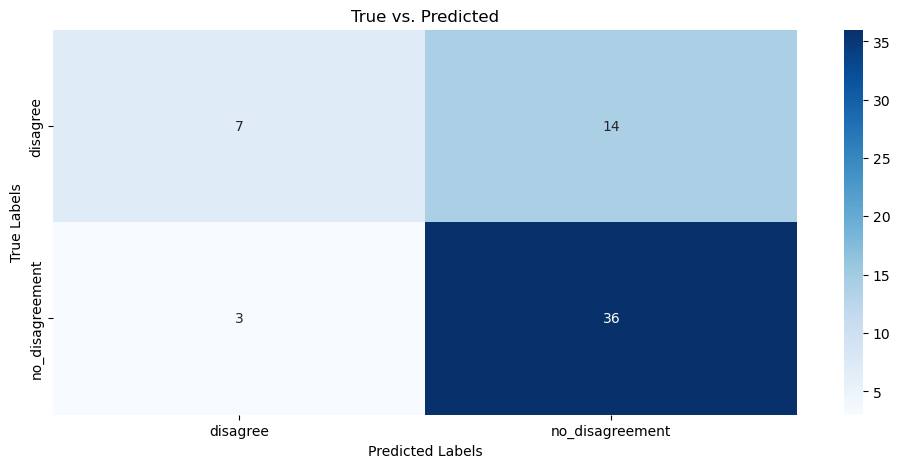

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(12, 5))  


print_cm(
    axis=axes,
    df = result,
    true_col = "majority_label",
    pred_col = "predictions_ft",
    title='True vs. Predicted'
)

label_c
no_disagreement    34
disagree           26
Name: count, dtype: int64
label_e
no_disagreement    47
disagree           13
Name: count, dtype: int64


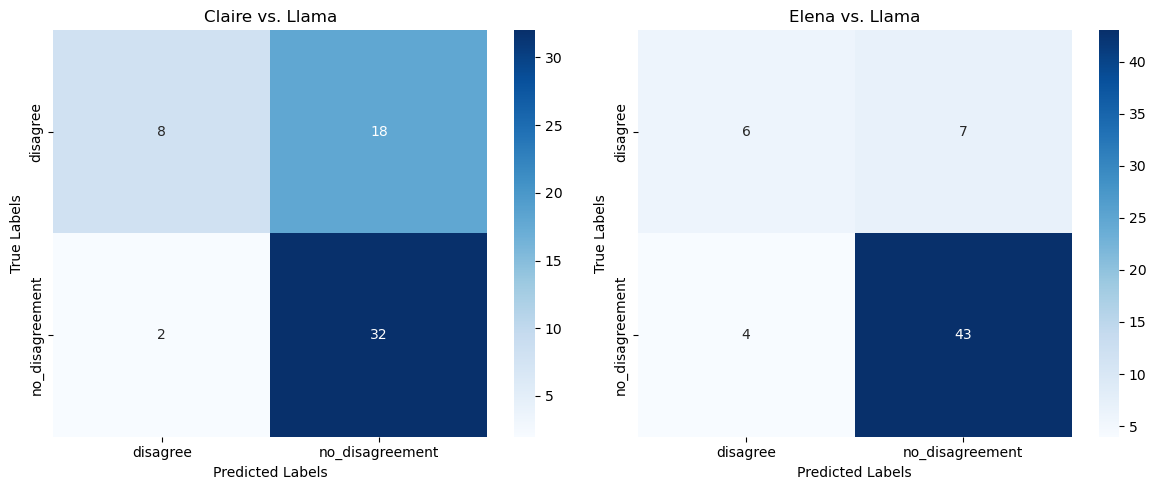

In [34]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
print_cm(
    axis=axes[0],
    df = result,
    true_col = "label_c",
    pred_col = "predictions_ft",
    title='Claire vs. Llama'
)

# Second matrix
print_cm(
    axis=axes[1],
    df = result,
    true_col = "label_e",
    pred_col = "predictions_ft",
    title='Elena vs. Llama'
)

plt.tight_layout()
plt.show()

# **To Latex**

In [36]:
y_test = result.label_e
y_pred = result['predictions_ft']

report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Export to LaTeX table
latex_code = df.to_latex(float_format="%.2f", index=True, caption="Classification Report per Label")
print(latex_code)

\begin{table}
\caption{Classification Report per Label}
\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
disagree & 0.60 & 0.46 & 0.52 & 13.00 \\
no_disagreement & 0.86 & 0.91 & 0.89 & 47.00 \\
accuracy & 0.82 & 0.82 & 0.82 & 0.82 \\
macro avg & 0.73 & 0.69 & 0.70 & 60.00 \\
weighted avg & 0.80 & 0.82 & 0.81 & 60.00 \\
\bottomrule
\end{tabular}
\end{table}

